# Dynamic Time Warping

Based on:
http://nipunbatra.github.io/2014/07/dtw/  

Other sources of information about DTW:  
https://pypi.python.org/pypi/dtw/1.0  
https://github.com/pierre-rouanet/dtw  
http://mlpy.sourceforge.net/docs/3.5/dtw.html  
http://alexminnaar.com/time-series-classification-and-clustering-with-python.html  
http://www.psb.ugent.be/cbd/papers/gentxwarper/DTWalgorithm.htm  
https://www.researchgate.net/profile/Pavel_Senin/publication/228785661_Dynamic_Time_Warping_Algorithm_Review/links/02bfe5100f11a7929f000000.pdf  
http://insy.ewi.tudelft.nl/content/multi-dimensional-dynamic-time-warping-gesture-recognition  
http://epubs.siam.org/doi/pdf/10.1137/1.9781611972757.50  
http://www.mblondel.org/journal/2009/08/31/dynamic-time-warping-theory/  
http://dx.doi.org/10.1371/journal.pone.0136577  
https://docs.google.com/viewer?url=http%3A%2F%2Fwww.psb.ugent.be%2Fcbd%2Fpapers%2Fgentxwarper%2FDTWAlgorithm.ppt  
http://www.cs.rutgers.edu/~mlittman/courses/lightai03/DDTW-2001.pdf  
http://www.ece.ucsb.edu/Faculty/Rabiner/ece259/Reprints/132_dtw.pdf


In [1]:
import numpy
import matplotlib.pyplot as plt
import matplotlib 
%matplotlib inline
import ctypes
import sys

In [2]:
%%file dtw_python.c

#include <stdlib.h>
#include <stdio.h>
#include <math.h>
#include <string.h> // only for the memcpy
#include <errno.h>

/*
    Note: 
    Using ctypes, numpy arrays always look like a vector in C, not a matrix (even if the numpy array IS a matrix)
    The reason is that numpy matrices are always arrays also inside numpy :)    
*/

float path_cost(int len_x, int len_y, float *accumulated_cost, float *distances);
void generates_accumulated_cost(int len_x, int len_y, float *accumulated_cost, float *distances);
void generates_distances(int len_x, int len_y, int dim, float *distances, float *x, float *y);
void returns_path(int *output, int size);

int *path = NULL;
int path_counter = 0;


int returns_path_length(){
    return path_counter;
}

void returns_path(int *output, int size){
    memcpy(output,path,2*sizeof(int)*size);
    free(path);
    path = NULL;
}

float path_cost(int len_x, int len_y, float *accumulated_cost, float *distances)
{
    int i = len_x-1;
    int j = len_y-1;
    int n_malloc_i = 1;
    float min_value = 0;
    float cost = 0;

    path_counter = 0;
    
    if (path == NULL)
    {
        path = malloc(100*2*sizeof(int));
        if (path==NULL)
            return EXIT_FAILURE;
    }
    else
    {
        free(path);
        path = NULL;
        path = malloc(100*2*sizeof(int));
        if (path==NULL)
            return EXIT_FAILURE;        
    }
    
    *path = i;
    *(path+1) = j;
    path_counter++;
    
    while((i>0)||(j>0))
    {        
        if(i==0)
            j = j - 1;
        else if(j==0)
            i = i - 1;
        else
        {
            // Calculates the min value
            if (*(accumulated_cost+((i-1)*len_y)+(j-1))>*(accumulated_cost+((i-1)*len_y)+j))
                min_value = *(accumulated_cost+len_y*(i-1)+j);
            else if (*(accumulated_cost+((i-1)*len_y)+(j-1))>*(accumulated_cost+(i*len_y)+(j-1)))
                min_value = *(accumulated_cost+(i*len_y)+(j-1));
            else
                min_value = *(accumulated_cost+((i-1)*len_y)+(j-1));

            // Calculates the next step based on the min value
            if (*(accumulated_cost+len_y*(i-1)+j) == min_value)
                i = i - 1;
            else if (*(accumulated_cost+len_y*i+(j-1)) == min_value)
                j = j - 1;
            else
            {
                i = i - 1;
                j = j - 1;
            }
        }
                         
        if (((float)path_counter/n_malloc_i)<100)
        {
            *(path+path_counter*2)=i;
            *(path+path_counter*2+1)=j;
            path_counter++;
        }
        else
        {
            n_malloc_i++;
            path = realloc(path,n_malloc_i*100*2*sizeof(int));
            
            if (path==NULL)
                return EXIT_FAILURE;            
            
            *(path+path_counter*2)=i;
            *(path+path_counter*2+1)=j;
            path_counter++;
        }
    }
    for (int i=0; i<path_counter; i++)
    {
        const int x = *(path+i*2);
        const int y = *(path+i*2+1);        
        cost = cost + *(distances+len_y*x+y);
    }
                         
    return cost;
}


void generates_accumulated_cost(int len_x, int len_y, float *accumulated_cost, float *distances)
{
    float min_value = 0;
    
    *(accumulated_cost)= *(distances);
    
    for (int i=1; i<len_y; i++)
        *(accumulated_cost+i) = *(distances+i) + *(accumulated_cost+i-1);
    
    for (int j=1; j<len_x; j++)
        *(accumulated_cost+(j*len_y)) = *(distances+(j*len_y)) + *(accumulated_cost+((j-1)*len_y));    

    for (int i=1; i<len_x; i++)
    {
        for (int j=1; j<len_y; j++)
        {
            // Calculates the min value
            if (*(accumulated_cost+((i-1)*len_y)+(j-1))>*(accumulated_cost+((i-1)*len_y)+j))
                min_value = *(accumulated_cost+len_y*(i-1)+j);
            else if (*(accumulated_cost+((i-1)*len_y)+(j-1))>*(accumulated_cost+(i*len_y)+(j-1)))
                min_value = *(accumulated_cost+(i*len_y)+(j-1));
            else
                min_value = *(accumulated_cost+((i-1)*len_y)+(j-1));

            *(accumulated_cost+(i*len_y)+j)= min_value + *(distances+(i*len_y)+j);
        }
        
    }
}

void generates_distances(int len_x, int len_y, int dim, float *distances, float *x, float *y)
{
    for (int i=0; i<len_x; i++)
    {
        for (int j=0; j<len_y; j++)
        {
            *(distances+(i*len_y)+j) = 0; //initialises
            
            if (dim>1)
                for (int d=0; d<dim; d++)
                {
                    *(distances+(i*len_y)+j) += pow(*(x+(i*dim)+d)-*(y+(j*dim)+d),2);
                }
            else
                *(distances+(i*len_y)+j) += pow(*(x+i)-*(y+j),2);
            
            *(distances+(i*len_y)+j) = sqrt(*(distances+(i*len_y)+j));
            
        }
    }
}


Overwriting dtw_python.c


In [3]:
# In Linux it's necessary to add these: -lrt -lm
!gcc -shared -Wl,-install_name,dtw_python.so -o dtw_python.so -fPIC dtw_python.c -O3 -std=gnu99 -Wall -ffast-math -mtune=native 

In [4]:
%%file dtw_C.py

import numpy
import ctypes

DTW=ctypes.CDLL("./dtw_python.so")

# void generates_distances(int len_x, int len_y, int dim, float *distances, float *x, float *y)
generates_distances = DTW.generates_distances
generates_distances.restype = None
generates_distances.argtypes = [
    ctypes.c_int32,
    ctypes.c_int32,
    ctypes.c_int32,
    numpy.ctypeslib.ndpointer(dtype=numpy.float32, flags='ALIGNED,C_CONTIGUOUS'),
    numpy.ctypeslib.ndpointer(dtype=numpy.float32, flags='ALIGNED,C_CONTIGUOUS'),
    numpy.ctypeslib.ndpointer(dtype=numpy.float32, flags='ALIGNED,C_CONTIGUOUS')]

def distances_matrix(x,y):

    assert len(x.shape)==len(y.shape), "Inputs must have the same number of columns"
    
    if len(x.shape)==1:
        dim = ctypes.c_int32(1)
    else:
        dim = ctypes.c_int32(x.shape[1])
    
    len_x = ctypes.c_int32(x.shape[0])
    len_y = ctypes.c_int32(y.shape[0]) 
    
    distances = numpy.empty((x.shape[0],y.shape[0]),dtype=numpy.float32)
    
    
    generates_distances(len_x, len_y, dim, distances, x.astype(dtype=numpy.float32), y.astype(dtype=numpy.float32))
    
    return distances#.reshape((x.shape[0],y.shape[0]))

# void generates_accumulated_cost(int len_x, int len_y, float *accumulated_cost, float *distances)
generates_accumulated_cost = DTW.generates_accumulated_cost
generates_accumulated_cost.restype = None
generates_accumulated_cost.argtypes = [
    ctypes.c_int32,
    ctypes.c_int32,
    numpy.ctypeslib.ndpointer(dtype=numpy.float32, flags='ALIGNED,C_CONTIGUOUS'),
    numpy.ctypeslib.ndpointer(dtype=numpy.float32, flags='ALIGNED,C_CONTIGUOUS')]

def accumulated_cost_matrix(x,y,distances):
    len_x = ctypes.c_int32(x.shape[0])
    len_y = ctypes.c_int32(y.shape[0]) 
    accumulated_cost = numpy.empty((x.shape[0],y.shape[0]),dtype=numpy.float32)
    
    generates_accumulated_cost(len_x, len_y, accumulated_cost, distances)
    
    return accumulated_cost

# float path_cost(int len_x, int len_y, float *accumulated_cost, float *distances)
path_cost = DTW.path_cost
path_cost.restype = ctypes.c_float
path_cost.argtypes = [
    ctypes.c_int32,
    ctypes.c_int32,
    numpy.ctypeslib.ndpointer(dtype=numpy.float32, flags='ALIGNED,C_CONTIGUOUS'),
    numpy.ctypeslib.ndpointer(dtype=numpy.float32, flags='ALIGNED,C_CONTIGUOUS')]

# int returns_path_length()
returns_path_length = DTW.returns_path_length
returns_path_length.restype = ctypes.c_int32
returns_path_length.argtypes = []

# void returns_path(int *output, int size)
returns_path = DTW.returns_path
returns_path.restype = None
returns_path.argtypes = [
    numpy.ctypeslib.ndpointer(dtype=numpy.int32, flags='ALIGNED,C_CONTIGUOUS'),
    ctypes.c_int32]


def path_cost_calculation(x,y,distances,accumulated_cost):
    len_x = ctypes.c_int32(x.shape[0])
    len_y = ctypes.c_int32(y.shape[0]) 
    
    cost = path_cost(len_x, len_y, accumulated_cost, distances)

    path_length = returns_path_length()
    
    path = numpy.empty((path_length,2),dtype=numpy.int32)
    
    returns_path(path, path_length)
    
    return path,cost

Overwriting dtw_C.py


In [5]:
import dtw_C
reload(sys.modules['dtw_C'])

<module 'dtw_C' from 'dtw_C.pyc'>

In [6]:
def distance_cost_plot(distances,all_ticks=False):
    distances=distances.T
    plt.figure(figsize =(10,10))
    im = plt.imshow(distances, interpolation='nearest', cmap='Reds') 
    plt.gca().invert_yaxis()
    plt.ylabel("y")
    plt.xlabel("x")
    if all_ticks:
        plt.xticks(range(distances.shape[1]),range(distances.shape[1]))
        plt.yticks(range(distances.shape[0]),range(distances.shape[0]))
    plt.grid()
    plt.colorbar();

In [7]:
def path_cost_p(x, y, accumulated_cost, distances):
    
    path = [[len(x)-1, len(y)-1]]
    
    cost = 0
    
    i = len(x)-1
    j = len(y)-1
    
    while i>0 or j>0:
        if i==0:
            j = j - 1
        elif j==0:
            i = i - 1
        else:
            if accumulated_cost[i-1, j] == min(accumulated_cost[i-1, j-1], accumulated_cost[i-1, j], accumulated_cost[i, j-1]):
                i = i - 1
            elif accumulated_cost[i, j-1] == min(accumulated_cost[i-1, j-1], accumulated_cost[i-1, j], accumulated_cost[i, j-1]):
                j = j - 1
            else:
                i = i - 1
                j = j - 1
        path.append([i, j])
    for [x, y] in path:
        cost = cost +distances[x, y]
    return path, cost

In [8]:
def generates_accumulated_cost_p(x,y,distances):
    accumulated_cost = numpy.zeros((len(x), len(y)))
    
    accumulated_cost[0,0] = distances[0,0]
    
    for i in range(1, len(x)):
        accumulated_cost[i,0] = distances[i, 0] + accumulated_cost[i-1, 0]

    for j in range(1, len(y)):
        accumulated_cost[0,j] = distances[0,j] + accumulated_cost[0, j-1]
        
    for i in range(1, len(x)):
        for j in range(1, len(y)):
            accumulated_cost[i, j] = min(accumulated_cost[i-1, j-1], accumulated_cost[i-1, j], accumulated_cost[i, j-1]) + distances[i, j]
            
    return accumulated_cost

In [9]:
def generates_distances2D(x,y):
    '''
    Generates the distance matrix used with Dynamic Time Warping
    '''
    # Creates the helper matrix
    helper_matrix=numpy.ones((y.shape[0],x.shape[0]))

    # Generates (y.shape[0]) copies of each value in original_drawing
    x_all=(x[:,0]*helper_matrix)
    y_all=(x[:,1]*helper_matrix)

    # returns all the distances between original points and generated ones
    return (numpy.sqrt((x_all.T-y[:,0])**2+(y_all.T-y[:,1])**2))

In [10]:
def generates_distances3D(x,y):
    '''
    Generates the distance matrix used with Dynamic Time Warping
    '''
    # Creates the helper matrix
    helper_matrix=numpy.ones((y.shape[0],x.shape[0]))

    # Generates (y.shape[0]) copies of each value in original_drawing
    x_all=(x[:,0]*helper_matrix)
    y_all=(x[:,1]*helper_matrix)
    z_all=(x[:,2]*helper_matrix)

    # returns all the distances between original points and generated ones
    return (numpy.sqrt((x_all.T-y[:,0])**2+(y_all.T-y[:,1])**2+(z_all.T-y[:,2])**2))

In [11]:
def generates_distances_N(x,y):
    '''
    Generates the distance matrix used with Dynamic Time Warping 
    => for systems with N dimensions
    '''
    assert len(x.shape)==len(y.shape), "Inputs must have the same number of columns"
    
    if len(x.shape)==1:
        x=x.reshape((x.shape[0],1))
        y=y.reshape((y.shape[0],1))
    
    assert x.shape[1]==y.shape[1], "Inputs must have the same number of columns" # verifies if the second dimension matches
    # Creates the helper matrix
    helper_matrix=numpy.ones((y.shape[0],x.shape[0]))

    # returns all the distances between original points and generated ones
    return (numpy.sqrt(numpy.array([((x[:,i]*helper_matrix).T-y[:,i])**2 for i in range(x.shape[1])]).sum(axis=0)))

# Examples

## Example 1
### Using only Numpy

[[ 0.  0.  0.  0.]
 [ 1.  1.  1.  1.]
 [ 2.  2.  2.  2.]
 [ 3.  3.  3.  3.]
 [ 4.  4.  4.  4.]]


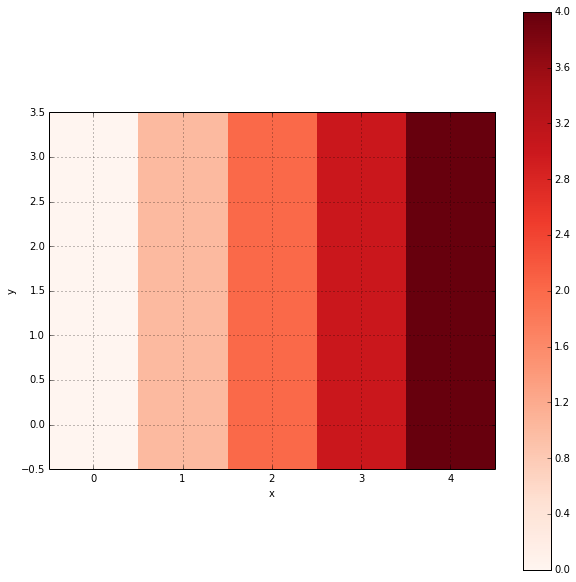

In [12]:
x = numpy.array([0,1,2,3,4])
y = numpy.zeros(4)

dist=generates_distances_N(x,y)
print dist
distance_cost_plot(dist)

### Using C version

[[ 0.  0.  0.  0.]
 [ 1.  1.  1.  1.]
 [ 2.  2.  2.  2.]
 [ 3.  3.  3.  3.]
 [ 4.  4.  4.  4.]]


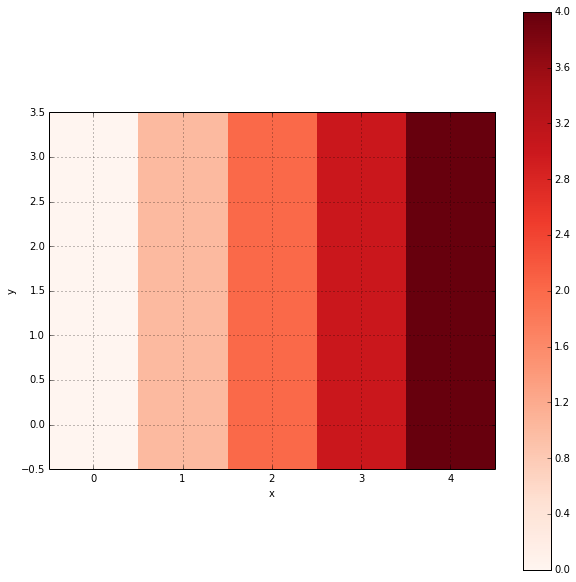

In [13]:
dist=dtw_C.distances_matrix(x,y)
print dist
distance_cost_plot(dist)

## Example 2
### Using only Numpy

[[ 0.  1.  2.  3.]
 [ 0.  1.  2.  3.]
 [ 0.  1.  2.  3.]]


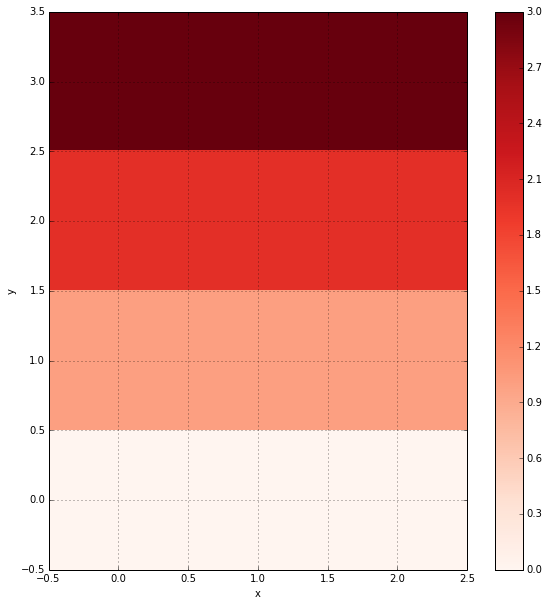

In [14]:
x = numpy.zeros(3)
y = numpy.array([0,1,2,3])

dist=generates_distances_N(x,y)
print dist
distance_cost_plot(dist)

### Using C version

[[ 0.  1.  2.  3.]
 [ 0.  1.  2.  3.]
 [ 0.  1.  2.  3.]]


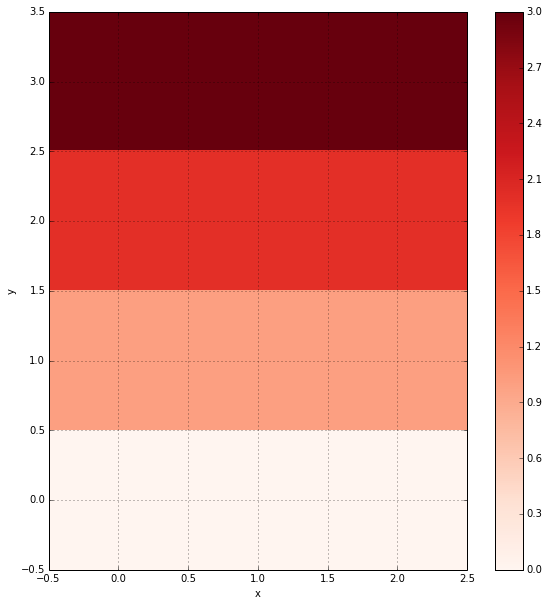

In [15]:
dist=dtw_C.distances_matrix(x,y)
print dist
distance_cost_plot(dist)

## Example 3
### Using only Numpy

[[ 1.  0.  1.]
 [ 0.  1.  0.]
 [ 0.  1.  0.]]


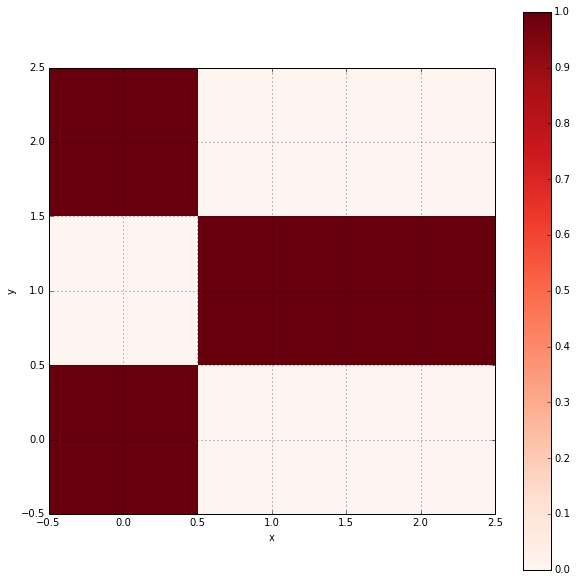

In [16]:
x = numpy.zeros((3,4))
y = numpy.zeros((3,4))

x[0,:]=[1,0,0,0]

y[1,:]=[1,0,0,0]

dist=generates_distances_N(x,y)
print dist
distance_cost_plot(dist)

### Using C version

[[ 1.  0.  1.]
 [ 0.  1.  0.]
 [ 0.  1.  0.]]


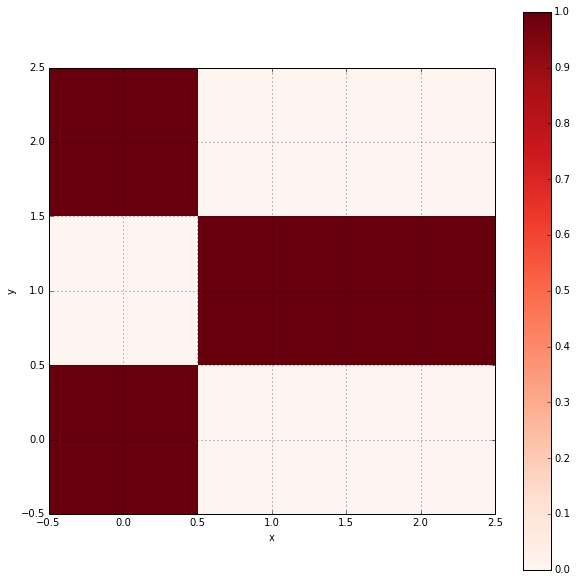

In [17]:
dist=dtw_C.distances_matrix(x,y)
print dist
distance_cost_plot(dist)

## Example 4
### Using only Numpy

[[ 1.          1.41421356  1.        ]
 [ 0.          1.          0.        ]
 [ 0.          1.          0.        ]]


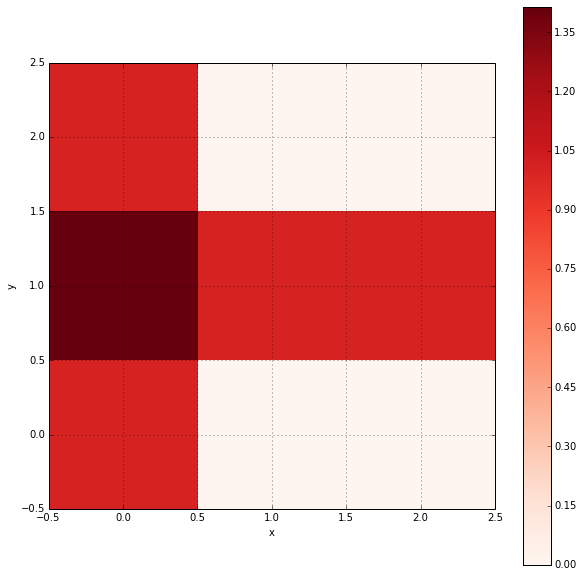

In [18]:
x = numpy.zeros((3,4))
y = numpy.zeros((3,4))

x[0,:]=[0,1,0,0]

y[1,:]=[1,0,0,0]

dist=generates_distances_N(x,y)
print dist
distance_cost_plot(dist)

### Using C version

[[ 1.          1.41421354  1.        ]
 [ 0.          1.          0.        ]
 [ 0.          1.          0.        ]]


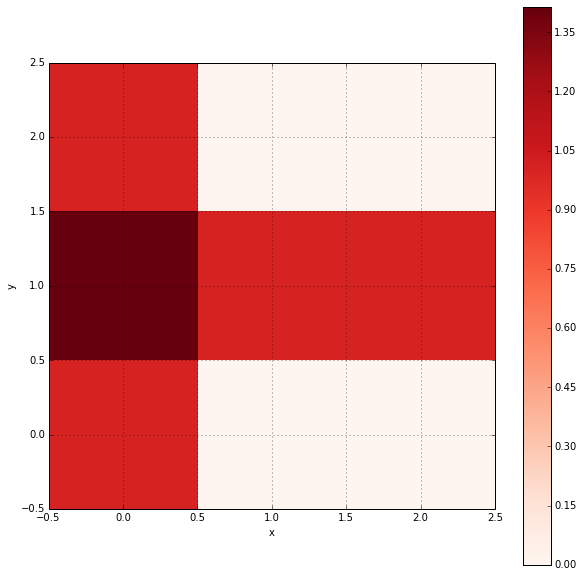

In [19]:
dist=dtw_C.distances_matrix(x,y)
print dist
distance_cost_plot(dist)

## Example 5
### Comparing speed between Numpy and C version

In [20]:
x = numpy.random.rand(300,4)
y = numpy.random.rand(500,4)

In [21]:
%%time
dist=generates_distances_N(x,y)

CPU times: user 4.94 ms, sys: 2.98 ms, total: 7.92 ms
Wall time: 7.17 ms


In [22]:
%%time
dist=dtw_C.distances_matrix(x,y)

CPU times: user 1.26 ms, sys: 420 µs, total: 1.68 ms
Wall time: 1.24 ms


In [23]:
%%time
accumulated_cost=dtw_C.accumulated_cost_matrix(x,y,dist)

CPU times: user 567 µs, sys: 244 µs, total: 811 µs
Wall time: 469 µs


In [24]:
%%time
path,cost = dtw_C.path_cost_calculation(x,y,dist,accumulated_cost)

CPU times: user 135 µs, sys: 25 µs, total: 160 µs
Wall time: 125 µs


In [25]:
x = numpy.random.rand(3000,3)
y = numpy.random.rand(5000,3)

In [26]:
%%time
dist=generates_distances_N(x,y)

CPU times: user 1 s, sys: 502 ms, total: 1.51 s
Wall time: 1.75 s


In [27]:
%%time
dist=generates_distances3D(x,y)

CPU times: user 425 ms, sys: 303 ms, total: 728 ms
Wall time: 735 ms


In [28]:
%%time
dist=dtw_C.distances_matrix(x,y)

CPU times: user 80.8 ms, sys: 14.8 ms, total: 95.5 ms
Wall time: 95.2 ms


In [29]:
x = numpy.random.rand(3000,2)
y = numpy.random.rand(5000,2)

In [30]:
%%time
dist=generates_distances_N(x,y)

CPU times: user 654 ms, sys: 240 ms, total: 895 ms
Wall time: 955 ms


In [31]:
%%time
dist=generates_distances2D(x,y)

CPU times: user 278 ms, sys: 164 ms, total: 441 ms
Wall time: 441 ms


In [32]:
%%time
dist=dtw_C.distances_matrix(x,y)

CPU times: user 56.3 ms, sys: 14.9 ms, total: 71.2 ms
Wall time: 70.7 ms


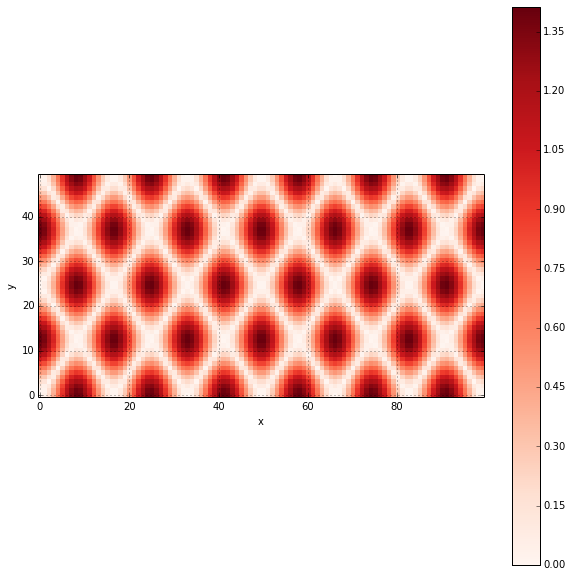

In [33]:
x = numpy.zeros((100,2))
x[:,1]=numpy.sin(numpy.linspace(0,6*numpy.pi,num=100))**2
x[:,0]=numpy.cos(numpy.linspace(0,6*numpy.pi,num=100))**2

y = numpy.zeros((50,2))
y[:,1]=numpy.sin(numpy.linspace(0,2*numpy.pi,num=50))**2
y[:,0]=numpy.cos(numpy.linspace(0,2*numpy.pi,num=50))**2

dist=generates_distances_N(x,y)
# print dist
distance_cost_plot(dist)

In [34]:
%%time
dist=generates_distances2D(x,y)

CPU times: user 124 µs, sys: 44 µs, total: 168 µs
Wall time: 132 µs


In [35]:
%%time
accumulated_cost=generates_accumulated_cost_p(x,y,dist)

CPU times: user 4.39 ms, sys: 1.78 ms, total: 6.17 ms
Wall time: 4.7 ms


In [36]:
%%time
path,cost = path_cost_p(x, y, accumulated_cost, dist)
path=numpy.array(path)
print cost

31.6004724461
CPU times: user 285 µs, sys: 79 µs, total: 364 µs
Wall time: 312 µs


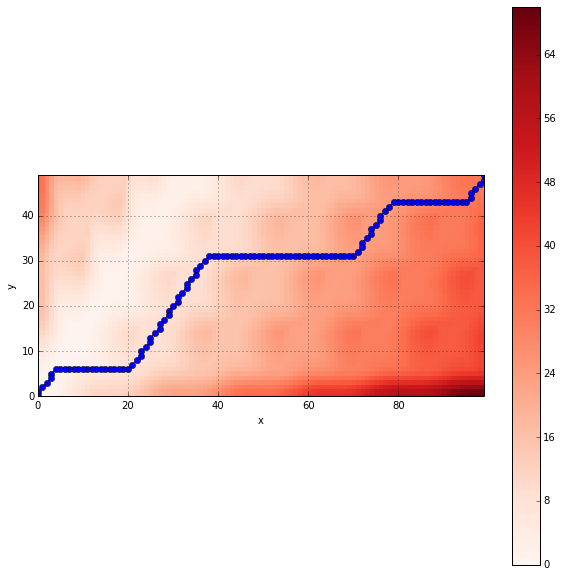

In [37]:
distance_cost_plot(accumulated_cost)
plt.plot(path[:,0],path[:,1],'o-')
plt.xlim(0,path[0,0])
plt.ylim(0,path[0,1])
plt.show()

In [38]:
%%time
dist=dtw_C.distances_matrix(x,y)

CPU times: user 129 µs, sys: 26 µs, total: 155 µs
Wall time: 118 µs


In [39]:
%%time
accumulated_cost=dtw_C.accumulated_cost_matrix(x,y,dist)

CPU times: user 90 µs, sys: 22 µs, total: 112 µs
Wall time: 91.1 µs


In [40]:
%%time
path,cost = dtw_C.path_cost_calculation(x,y,dist,accumulated_cost)
print cost

31.6004676819
CPU times: user 82 µs, sys: 12 µs, total: 94 µs
Wall time: 84.2 µs


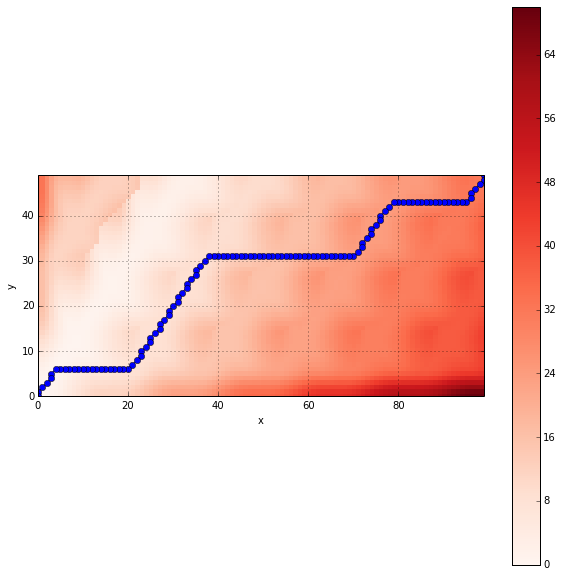

In [41]:
distance_cost_plot(accumulated_cost)
plt.plot(path[:,0],path[:,1],'o-')
plt.xlim(0,path[0,0])
plt.ylim(0,path[0,1])
plt.show()

## Example 6
### Reproducing the sin / cosine example from http://nipunbatra.github.io/2014/07/dtw/

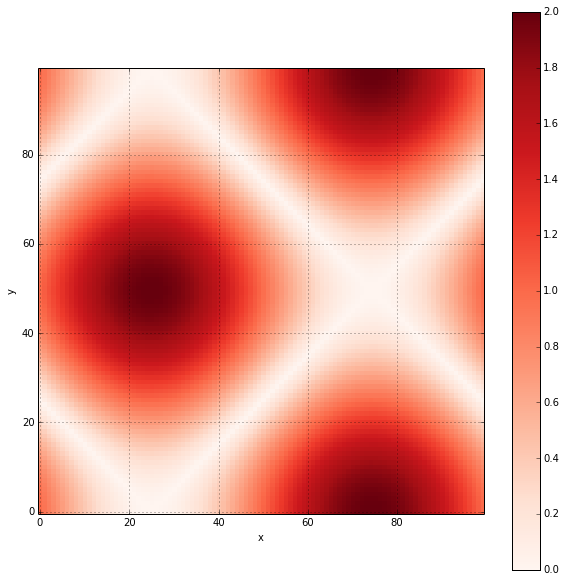

In [42]:
idx = numpy.linspace(0, 6.28, 100)
idy = numpy.linspace(0, 6.28, 100)
x = numpy.sin(idx)
y = numpy.cos(idy)
dist=dtw_C.distances_matrix(x,y)
distance_cost_plot(dist)

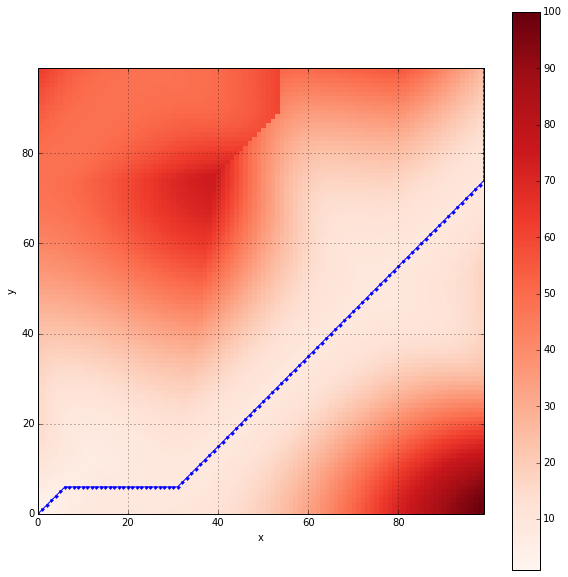

In [43]:
accumulated_cost=dtw_C.accumulated_cost_matrix(x,y,dist)
path,cost = dtw_C.path_cost_calculation(x,y,dist,accumulated_cost)

distance_cost_plot(accumulated_cost)
plt.plot(path[:,0],path[:,1],'.-')
plt.xlim(0,path[0,0])
plt.ylim(0,path[0,1])
plt.show()

In [44]:
cost, \
numpy.array([dist[i,j] for i,j in zip(path[:,0],path[:,1])]).sum(),\
numpy.array([accumulated_cost[i,j] for i,j in zip(path[:,0],path[:,1])]).sum(),\
accumulated_cost[-1,-1]/sum(accumulated_cost.shape) # Same cost as in https://pypi.python.org/pypi/dtw/1.0

(25.869733810424805, 25.869736, 1252.7753, 0.12934865951538085)

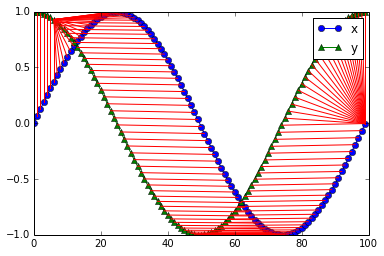

In [45]:
plt.plot(x, 'bo-' ,label='x')
plt.plot(y, 'g^-', label = 'y')
plt.legend();
for [map_x, map_y] in path:
    plt.plot([map_x, map_y], [x[map_x], y[map_y]], 'r')

# Example 9 

In [46]:
from dtw import dtw
# https://pypi.python.org/pypi/dtw/1.0

In [47]:
dist, cost, path = dtw(x, y)

In [48]:
dist

0.12934867932415128

In [49]:
cost_array=[cost[i,j] for i,j in zip(path[0],path[1])]

In [50]:
numpy.array(cost_array).sum()

1253.775417082491

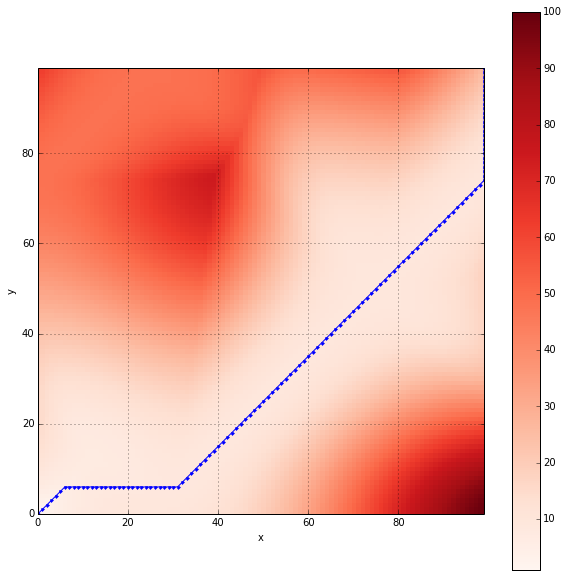

In [52]:
distance_cost_plot(cost)
plt.plot(path[0], path[1],'.-')
plt.xlim(0,path[0][-1])
plt.ylim(0,path[1][-1])
plt.show()

# Example 8 - Speech recognition?
## It's necessary to install portaudio (brew install portaudio) and pyaudio (pip install pyaudio)

In [41]:
samples = [] # list used to save the different recordings

In [55]:
# Records directly from the computer microphone

# http://stackoverflow.com/a/29722090
import pyaudio

RATE = 16000
RECORD_SECONDS = 2.5
CHUNKSIZE = 1024

# initialize portaudio
p = pyaudio.PyAudio()
stream = p.open(format=pyaudio.paInt16, channels=1, rate=RATE, input=True, frames_per_buffer=CHUNKSIZE)

frames = [] # A python-list of chunks(numpy.ndarray)
for _ in range(0, int(RATE / CHUNKSIZE * RECORD_SECONDS)):
    data = stream.read(CHUNKSIZE)
    frames.append(numpy.fromstring(data, dtype=numpy.int16))

#Convert the list of numpy-arrays into a 1D array (column-wise)
numpydata = numpy.hstack(frames)

# close stream
stream.stop_stream()
stream.close()
p.terminate()

samples.append(numpydata)

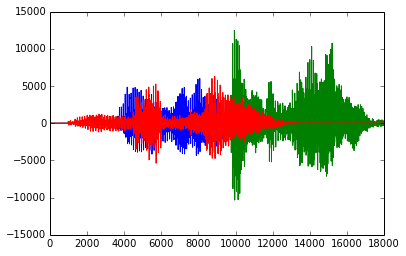

In [74]:
# plot data
import matplotlib.pyplot as plt
%matplotlib inline

for s in samples:
    plt.plot(s[8000:26000])
plt.show()

In [75]:
x = (samples[0][8000:26000])[::4]
y = (samples[2][8000:26000])[::4]

In [76]:
dist=dtw_C.distances_matrix(x,y)

In [77]:
accumulated_cost=dtw_C.accumulated_cost_matrix(x,y,dist)

In [78]:
path,cost = dtw_C.path_cost_calculation(x,y,dist,accumulated_cost)

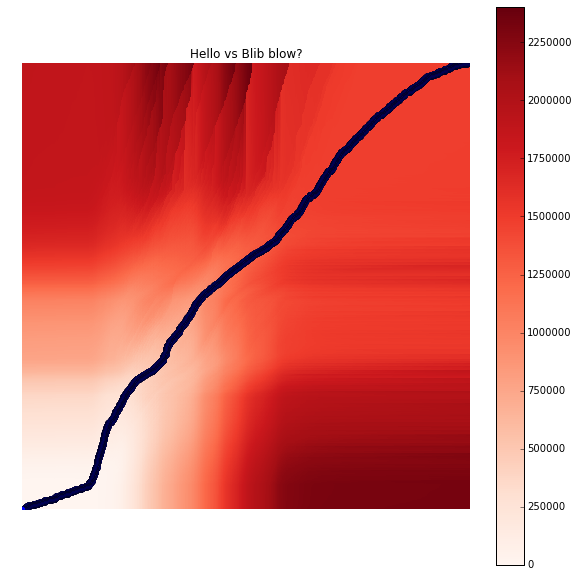

In [79]:
distance_cost_plot(accumulated_cost)
plt.plot(path[:,0],path[:,1],'o-')
plt.axis('off')
plt.xticks([],[])# avoids white spaces
plt.yticks([],[])# avoids white spaces
plt.title("Hello vs Blib blow?")
plt.show()

In [80]:
x = (samples[0][8000:26000])[::4]
y = (samples[1][8000:26000])[::4]

In [81]:
dist=dtw_C.distances_matrix(x,y)

In [82]:
accumulated_cost=dtw_C.accumulated_cost_matrix(x,y,dist)

In [83]:
path,cost = dtw_C.path_cost_calculation(x,y,dist,accumulated_cost)

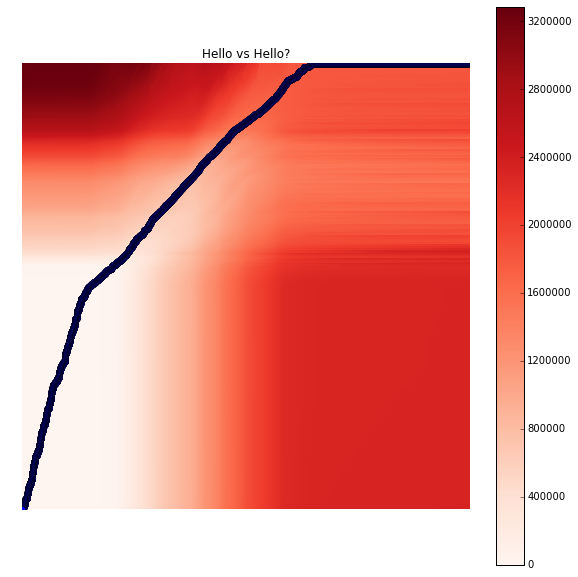

In [84]:
distance_cost_plot(accumulated_cost)
plt.plot(path[:,0],path[:,1],'o-')
plt.axis('off')
plt.xticks([],[])# avoids white spaces
plt.yticks([],[])# avoids white spaces
plt.title("Hello vs Hello?")
plt.show()